In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns; sns.set()
from qbstyles import mpl_style
# from datetime import datetime as pdt
import numpy as np
from io import StringIO
from datetime import datetime as dt, timedelta as td
import requests

### Download the data
This will take a few minutes, so grab a drink
<br>
<br>
The '08-16-2020' end date value can be replaced with pdt.today() for today's date
Keep in mind that the daily update schedules vary and may not have happened yet

In [13]:
end_date = dt.today() - td(days=1)
dateRange = pd.date_range('04-12-2020', end_date)
us_data, pa_data, mont_data = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# temp_df = pd.read_csv(StringIO(requests.get(csv_link).content.decode()))

# For each region we need to narrow down to relevant rows
for date in dateRange:
    df = pd.read_csv(StringIO(requests.get("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/" + date.strftime('%m-%d-%Y') + '.csv').content.decode()))
    df = df[['FIPS','Province_State','Country_Region','Confirmed']]
    us_df = df.query('Country_Region == "US"')
    us_df = us_df.groupby('Country_Region').aggregate({'FIPS':max,
                                            'Province_State':max,
                                            'Confirmed':sum})

    pa_df = df.query('Country_Region == "US" and Province_State == "Pennsylvania"')
    pa_df = pa_df.groupby('Province_State').aggregate({'FIPS':max,
                                            'Country_Region':max,
                                            'Confirmed':sum})
    mont_df = df.query('FIPS == 42091') # Code for PA Montgom County
    
    if us_data.empty:
        us_data = us_df
        pa_data = pa_df
        mont_data = mont_df      
    else:
        #After the first iteration, start concatenating results    
        us_data = pd.concat((us_data,us_df), ignore_index=True)
        pa_data = pd.concat((pa_data,pa_df), ignore_index=True)
        mont_data = pd.concat((mont_data,mont_df), ignore_index=True)

# Set the time series Index
us_data.index = dateRange; pa_data.index = dateRange; mont_data.index = dateRange


### Create New Daily Cases column
So in each file we're given the cumulative sum to date
<br>
we need to create a dataset for new unique daily values by subtracting each day's daily sum by the previous day's

In [14]:
# We only care about the Confirmed cases column right now
us_data = us_data[['Confirmed']]; pa_data = pa_data[['Confirmed']]; mont_data = mont_data[['Confirmed']]

# For each row subtract the value of the previous row to find new unique cases
for data_set in [us_data, pa_data, mont_data]:
    prev = 0
    new_cases = []
    for row in data_set.iterrows():        
        ind = row[1].loc['Confirmed']
        new_cases.append(ind - prev)
        prev = ind
    data_set['New_Cases'] = pd.DataFrame({'New_Cases':new_cases}, index=dateRange)

# The first of the Cases Per Day should be 0 since that is our starting point
us_data.loc['04-12-2020','New_Cases'] = 0; pa_data.loc['04-12-2020','New_Cases'] = 0; mont_data.loc['04-12-2020','New_Cases'] = 0
mont_data

,Confirmed,New_Cases
2020-04-12,2215,0
2020-04-13,2337,122
2020-04-14,2410,73
2020-04-15,2531,121
2020-04-16,2616,85
...,...,...
2021-12-11,97164,511
2021-12-12,97641,477
2021-12-13,97996,355
2021-12-14,98316,320


In [15]:
# Create the weekly-averaged resampled data
us_data_rs = us_data.resample('W')[['New_Cases']].mean()
pa_data_rs = pa_data.resample('W')[['New_Cases']].mean()
mont_data_rs = mont_data.resample('W')[['New_Cases']].mean()

## Plot Daily Cases

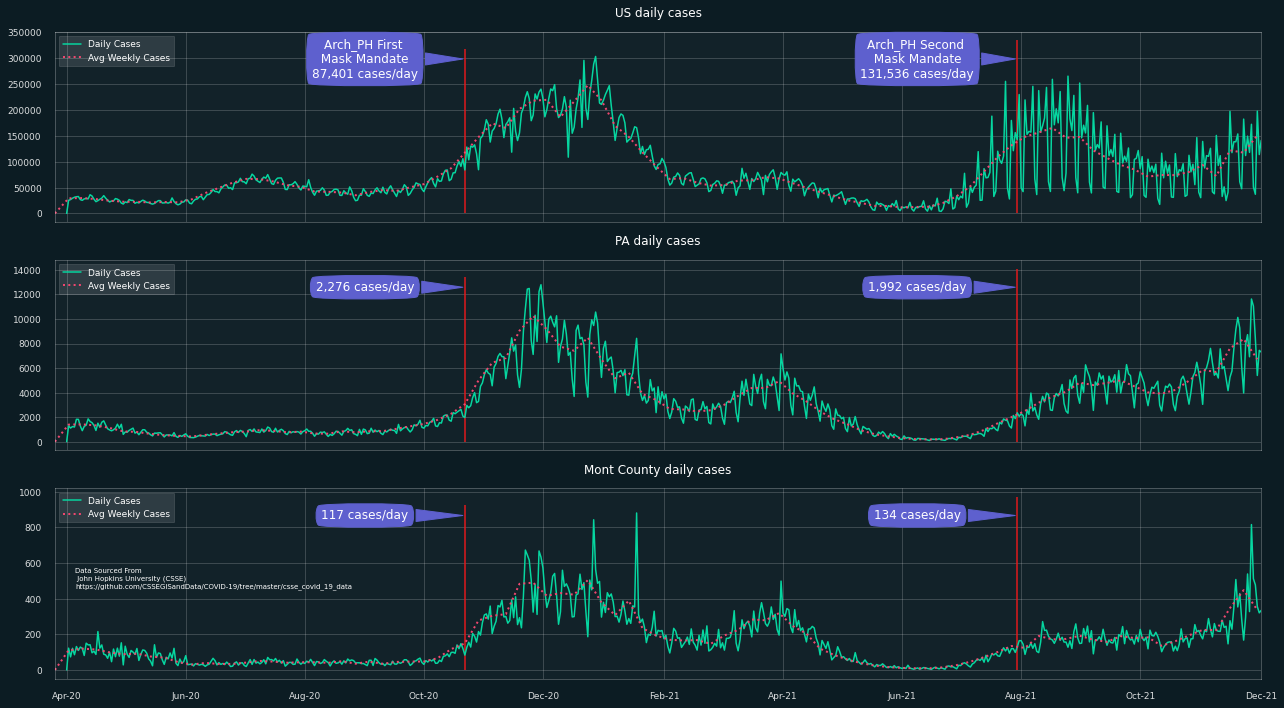

In [16]:
# Style
mpl_style(dark = True)

fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(18,10), sharex=True)

# Format the tick labels
xticks = pd.date_range(dateRange[0], dateRange[-1], periods=11)
xlabels = [i.strftime('%b-%y') for i in xticks]

# Plot the daily and averaged cases
us_data.plot(y='New_Cases',ax=ax[0], legend=False, title='US daily cases', c='#06d6a0', label='Daily Cases')
us_data_rs.plot(y='New_Cases',ax=ax[0], legend=False, c='#ef476f', ls=':', lw=2, label='Avg Weekly Cases')
pa_data.plot(y='New_Cases',ax=ax[1], legend=False, title='PA daily cases', c='#06d6a0', label='Daily Cases')
pa_data_rs.plot(y='New_Cases',ax=ax[1], legend=False, c='#ef476f', ls=':', lw=2, label='Avg Weekly Cases')
mont_data.plot(y='New_Cases',ax=ax[2], legend=False, title='Mont County daily cases', c='#06d6a0', label='Daily Cases')
mont_data_rs.plot(y='New_Cases',ax=ax[2], legend=False, c='#ef476f', ls=':', lw=2, label='Avg Weekly Cases')

# Add veritical lines, legends
for sub_ax in ax.flat:
    sub_ax.vlines(x=pdt.strptime('2020-11-02', '%Y-%m-%d'),ymin=0, ymax=sub_ax.get_ylim()[1])
    sub_ax.vlines(x=pdt.strptime('2021-08-12', '%Y-%m-%d'),ymin=0, ymax=sub_ax.get_ylim()[1])
    sub_ax.legend(loc='upper left')

# Create Arrow annotations
bbox = dict(boxstyle='round4, pad=0.5', fc='#5e60ce', ec='#5e60ce')
arrowprops = dict(arrowstyle='wedge, tail_width=1.0', color='#5e60ce')

ax[0].annotate('Arch_PH First \n Mask Mandate \n' + "{:,.0f}".format(us_data_rs.loc["2020-11-01", "New_Cases"]) + ' cases/day', xy=('2020-11-02',ax[0].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)
ax[0].annotate('Arch_PH Second \n Mask Mandate \n' + "{:,.0f}".format(us_data_rs.loc["2021-08-15", "New_Cases"]) + ' cases/day', xy=('2021-08-12',ax[0].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)
ax[1].annotate("{:,.0f}".format(pa_data_rs.loc["2020-11-01", "New_Cases"]) + ' cases/day', xy=('2020-11-02',ax[1].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)
ax[1].annotate("{:,.0f}".format(pa_data_rs.loc["2021-08-15", "New_Cases"]) + ' cases/day', xy=('2021-08-12',ax[1].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)
ax[2].annotate("{:,.0f}".format(mont_data_rs.loc["2020-11-01", "New_Cases"]) + ' cases/day', xy=('2020-11-02',ax[2].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)
ax[2].annotate("{:,.0f}".format(mont_data_rs.loc["2021-08-15", "New_Cases"]) + ' cases/day', xy=('2021-08-12',ax[2].get_ylim()[1] * 0.85), xytext=(-100,0), textcoords='offset points', ha='center', va='center', bbox=bbox,arrowprops=arrowprops)


ax[2].annotate("Data Sourced From\n John Hopkins University (CSSE)\nhttps://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data", xy=(20,100), xycoords='axes points', ha='left', va='center', fontsize='xx-small')

# Set ticks from above
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xlabels)


fig.tight_layout()


In [17]:
fig.savefig('CasesPerDay.png')